In [175]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense


## Skip down to just read in the data

In [2]:
datapath = "../keypoints/"

In [98]:
kp_files = glob.glob(datapath + '*.txt')

In [4]:
# Get labels from file names
labels = [int(x.split('_')[0].split("/")[-1]) for x in kp_files]

In [99]:
# read in text files
len(labels)

259

In [210]:
# '''
# Note --- arrays are clipped at 440, because there's some variation around the dimension that is ~450
# '''

features = []
count = 1

for file in kp_files:
    print(count, end=" ")
    count += 1

    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["time", "kpoints", "count", "fps"]
    data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))
    times = [t-data.time[0] for t in data.time[0:440]]

    #Select upper body keypoints
    kp_ind = [0, 1, 2, 3, 4, 5, 6, 17]

    # matrix dims: time, kp, (kp_num, x, y)
    kp_mat = np.array(data.kpoints.tolist(), dtype=float)[0:440, kp_ind,:]

    kp_y = kp_mat[0:440, :,2]

    # R ear to R shoulder, L ear to L shoulder, nose to neck
    distances = [(2,6), (1,5), (0,7)]

    d_arr = []

    for tup in distances:
        p1x = kp_mat[:, tup[0], 1]
        p1y = kp_mat[:, tup[0], 2]
        p2x = kp_mat[:, tup[1], 1]
        p2y = kp_mat[:, tup[1], 2]

        dist = ((p1x-p2x)**2 + (p1y-p2y)**2)**.5    
        d_arr.append(dist)

    d_mat = np.array(d_arr).T

    t_mat = np.array(times).reshape(440, 1)

    full_mat = np.hstack((t_mat, kp_y, d_mat)).reshape(440, 12, 1)

    features.append(full_mat)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 

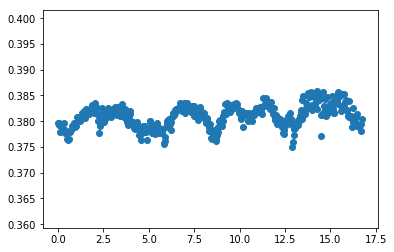

In [202]:
plt.scatter(t_mat, d_mat[:, 1])

## Write/read the data

In [302]:
# Save data, again

import pickle
# pickle.dump(features, open("features.txt", "wb"))
# pickle.dump(labels, open("labels.txt", "wb"))

In [122]:
# Read data
features = pickle.load(open("features.txt", "rb"))
labels = pickle.load(open("labels.txt", "rb"))

In [211]:
X = np.array(features)
print(X.shape)

(259, 440, 12, 1)


In [212]:
Y = np.array(labels)
print(Y.shape)

(259,)


(array([29., 16., 24., 22., 16., 24., 27., 16., 16., 30.]),
 array([ 8. , 11.3, 14.6, 17.9, 21.2, 24.5, 27.8, 31.1, 34.4, 37.7, 41. ]),
 <a list of 10 Patch objects>)

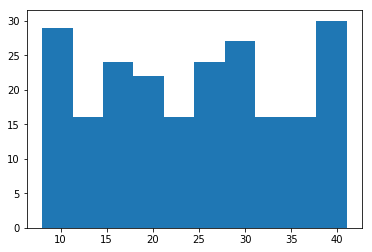

In [125]:
plt.hist(Y_train)

In [213]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=24601)

In [214]:
X_train.shape

(220, 440, 12, 1)

In [268]:
# normalize

train_mean = np.nanmean(X_train[:, :, 1:, :], axis=0)
train_std = np.nanstd(X_train[:, :, 1:, :], axis=0)

train_mean = np.hstack((np.zeros((440, 1, 1)), train_mean))
train_std = np.hstack((np.ones((440, 1, 1)), train_std))

train_mean.shape

(440, 12, 1)

In [269]:
X_train_sc = np.nan_to_num((X_train - train_mean)/train_std)

In [270]:
X_test_sc = np.nan_to_num((X_test - train_mean)/train_std)

In [271]:
model = tf.keras.Sequential([
    Convolution2D(filters=16, kernel_size = (30,12), strides=(2), 
                  padding="valid", 
                  input_shape=(440, 12, 1),
                  data_format="channels_last",
                  activation="relu"),
#     MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
#     Dense(256, input_shape=(440,2, 9), kernel_initializer="normal", activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])



In [292]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["mse", "mae"])

In [293]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 206, 1, 16)        5776      
_________________________________________________________________
flatten_4 (Flatten)          (None, 3296)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                52752     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 58,545
Trainable params: 58,545
Non-trainable params: 0
_________________________________________________________________


In [298]:
history = model.fit(X_train_sc, Y_train, epochs=3000)

Train on 220 samples
Epoch 1/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.3746 - mean_squared_error: 0.3746 - mean_absolute_error: 0.4472
Epoch 2/3000
220/220 [==============================] - 0s 923us/sample - loss: 0.3597 - mean_squared_error: 0.3597 - mean_absolute_error: 0.4242
Epoch 3/3000
220/220 [==============================] - 0s 892us/sample - loss: 0.3669 - mean_squared_error: 0.3669 - mean_absolute_error: 0.4082
Epoch 4/3000
220/220 [==============================] - 0s 683us/sample - loss: 0.2927 - mean_squared_error: 0.2927 - mean_absolute_error: 0.3601
Epoch 5/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.3087 - mean_squared_error: 0.3087 - mean_absolute_error: 0.3646
Epoch 6/3000
220/220 [==============================] - 0s 710us/sample - loss: 0.3455 - mean_squared_error: 0.3455 - mean_absolute_error: 0.3882
Epoch 7/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.3278 - mean_squared_error: 

220/220 [==============================] - 0s 878us/sample - loss: 0.3258 - mean_squared_error: 0.3258 - mean_absolute_error: 0.4108
Epoch 56/3000
220/220 [==============================] - 0s 884us/sample - loss: 0.3265 - mean_squared_error: 0.3265 - mean_absolute_error: 0.3996
Epoch 57/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.3575 - mean_squared_error: 0.3575 - mean_absolute_error: 0.4432
Epoch 58/3000
220/220 [==============================] - 0s 971us/sample - loss: 0.3730 - mean_squared_error: 0.3730 - mean_absolute_error: 0.4414
Epoch 59/3000
220/220 [==============================] - 0s 752us/sample - loss: 0.4214 - mean_squared_error: 0.4214 - mean_absolute_error: 0.4617
Epoch 60/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.3601 - mean_squared_error: 0.3601 - mean_absolute_error: 0.4403
Epoch 61/3000
220/220 [==============================] - 0s 948us/sample - loss: 0.3001 - mean_squared_error: 0.3001 - mean_absolute_err

220/220 [==============================] - 0s 820us/sample - loss: 0.2563 - mean_squared_error: 0.2563 - mean_absolute_error: 0.3319
Epoch 111/3000
220/220 [==============================] - 0s 801us/sample - loss: 0.2611 - mean_squared_error: 0.2611 - mean_absolute_error: 0.3518
Epoch 112/3000
220/220 [==============================] - 0s 942us/sample - loss: 0.2600 - mean_squared_error: 0.2600 - mean_absolute_error: 0.3501
Epoch 113/3000
220/220 [==============================] - 0s 965us/sample - loss: 0.2632 - mean_squared_error: 0.2632 - mean_absolute_error: 0.3523
Epoch 114/3000
220/220 [==============================] - 0s 814us/sample - loss: 0.3013 - mean_squared_error: 0.3013 - mean_absolute_error: 0.3926
Epoch 115/3000
220/220 [==============================] - 0s 879us/sample - loss: 0.2813 - mean_squared_error: 0.2813 - mean_absolute_error: 0.3631
Epoch 116/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.2693 - mean_squared_error: 0.2693 - mean_abso

220/220 [==============================] - 0s 1ms/sample - loss: 0.2700 - mean_squared_error: 0.2700 - mean_absolute_error: 0.3631
Epoch 166/3000
220/220 [==============================] - 0s 783us/sample - loss: 0.2511 - mean_squared_error: 0.2511 - mean_absolute_error: 0.3551
Epoch 167/3000
220/220 [==============================] - 0s 806us/sample - loss: 0.2618 - mean_squared_error: 0.2618 - mean_absolute_error: 0.3574
Epoch 168/3000
220/220 [==============================] - 0s 945us/sample - loss: 0.2509 - mean_squared_error: 0.2509 - mean_absolute_error: 0.3527
Epoch 169/3000
220/220 [==============================] - 0s 851us/sample - loss: 0.2813 - mean_squared_error: 0.2813 - mean_absolute_error: 0.3577
Epoch 170/3000
220/220 [==============================] - 0s 959us/sample - loss: 0.2407 - mean_squared_error: 0.2407 - mean_absolute_error: 0.3342
Epoch 171/3000
220/220 [==============================] - 0s 744us/sample - loss: 0.2507 - mean_squared_error: 0.2507 - mean_abso

220/220 [==============================] - 0s 1ms/sample - loss: 0.2392 - mean_squared_error: 0.2392 - mean_absolute_error: 0.3570
Epoch 220/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.2093 - mean_squared_error: 0.2093 - mean_absolute_error: 0.3172
Epoch 221/3000
220/220 [==============================] - 0s 825us/sample - loss: 0.2064 - mean_squared_error: 0.2064 - mean_absolute_error: 0.2982
Epoch 222/3000
220/220 [==============================] - 0s 826us/sample - loss: 0.1889 - mean_squared_error: 0.1889 - mean_absolute_error: 0.2833
Epoch 223/3000
220/220 [==============================] - 0s 717us/sample - loss: 0.2140 - mean_squared_error: 0.2140 - mean_absolute_error: 0.3139
Epoch 224/3000
220/220 [==============================] - 0s 751us/sample - loss: 0.1865 - mean_squared_error: 0.1865 - mean_absolute_error: 0.2781
Epoch 225/3000
220/220 [==============================] - 0s 729us/sample - loss: 0.1924 - mean_squared_error: 0.1924 - mean_absolu

220/220 [==============================] - 0s 1ms/sample - loss: 0.2433 - mean_squared_error: 0.2433 - mean_absolute_error: 0.3583
Epoch 275/3000
220/220 [==============================] - 0s 853us/sample - loss: 0.2064 - mean_squared_error: 0.2064 - mean_absolute_error: 0.3081
Epoch 276/3000
220/220 [==============================] - 0s 1000us/sample - loss: 0.2156 - mean_squared_error: 0.2156 - mean_absolute_error: 0.3265- loss: 0.1670 - mean_squared_error: 0.1670 - mean_absolute_error: 0.
Epoch 277/3000
220/220 [==============================] - 0s 857us/sample - loss: 0.1889 - mean_squared_error: 0.1889 - mean_absolute_error: 0.3112
Epoch 278/3000
220/220 [==============================] - 0s 795us/sample - loss: 0.2047 - mean_squared_error: 0.2047 - mean_absolute_error: 0.3315
Epoch 279/3000
220/220 [==============================] - 0s 739us/sample - loss: 0.2010 - mean_squared_error: 0.2010 - mean_absolute_error: 0.2976
Epoch 280/3000
220/220 [==============================] - 0

220/220 [==============================] - 0s 812us/sample - loss: 0.1513 - mean_squared_error: 0.1513 - mean_absolute_error: 0.2591
Epoch 329/3000
220/220 [==============================] - 0s 625us/sample - loss: 0.1584 - mean_squared_error: 0.1584 - mean_absolute_error: 0.2705
Epoch 330/3000
220/220 [==============================] - 0s 855us/sample - loss: 0.1824 - mean_squared_error: 0.1824 - mean_absolute_error: 0.3104
Epoch 331/3000
220/220 [==============================] - 0s 909us/sample - loss: 0.2103 - mean_squared_error: 0.2103 - mean_absolute_error: 0.3348
Epoch 332/3000
220/220 [==============================] - 0s 880us/sample - loss: 0.2122 - mean_squared_error: 0.2122 - mean_absolute_error: 0.3342
Epoch 333/3000
220/220 [==============================] - 0s 917us/sample - loss: 0.2183 - mean_squared_error: 0.2183 - mean_absolute_error: 0.3514
Epoch 334/3000
220/220 [==============================] - 0s 880us/sample - loss: 0.2607 - mean_squared_error: 0.2607 - mean_ab

220/220 [==============================] - 0s 829us/sample - loss: 0.1639 - mean_squared_error: 0.1639 - mean_absolute_error: 0.2819
Epoch 383/3000
220/220 [==============================] - 0s 899us/sample - loss: 0.1612 - mean_squared_error: 0.1612 - mean_absolute_error: 0.2784
Epoch 384/3000
220/220 [==============================] - 0s 863us/sample - loss: 0.1543 - mean_squared_error: 0.1543 - mean_absolute_error: 0.2679
Epoch 385/3000
220/220 [==============================] - 0s 808us/sample - loss: 0.1593 - mean_squared_error: 0.1593 - mean_absolute_error: 0.2698
Epoch 386/3000
220/220 [==============================] - 0s 863us/sample - loss: 0.1598 - mean_squared_error: 0.1598 - mean_absolute_error: 0.2789 - loss: 0.1608 - mean_squared_error: 0.1608 - mean_absolute_error: 0.28
Epoch 387/3000
220/220 [==============================] - 0s 883us/sample - loss: 0.1828 - mean_squared_error: 0.1828 - mean_absolute_error: 0.3008
Epoch 388/3000
220/220 [==============================]

220/220 [==============================] - 0s 1ms/sample - loss: 0.1766 - mean_squared_error: 0.1766 - mean_absolute_error: 0.3155
Epoch 437/3000
220/220 [==============================] - 0s 853us/sample - loss: 0.1710 - mean_squared_error: 0.1710 - mean_absolute_error: 0.3161
Epoch 438/3000
220/220 [==============================] - 0s 786us/sample - loss: 0.1550 - mean_squared_error: 0.1550 - mean_absolute_error: 0.2872
Epoch 439/3000
220/220 [==============================] - 0s 676us/sample - loss: 0.1483 - mean_squared_error: 0.1483 - mean_absolute_error: 0.2822
Epoch 440/3000
220/220 [==============================] - 0s 678us/sample - loss: 0.1563 - mean_squared_error: 0.1563 - mean_absolute_error: 0.2918
Epoch 441/3000
220/220 [==============================] - 0s 683us/sample - loss: 0.1675 - mean_squared_error: 0.1675 - mean_absolute_error: 0.2998
Epoch 442/3000
220/220 [==============================] - 0s 731us/sample - loss: 0.1421 - mean_squared_error: 0.1421 - mean_abso

220/220 [==============================] - 0s 986us/sample - loss: 0.1445 - mean_squared_error: 0.1445 - mean_absolute_error: 0.2858
Epoch 492/3000
220/220 [==============================] - 0s 888us/sample - loss: 0.1829 - mean_squared_error: 0.1829 - mean_absolute_error: 0.3270
Epoch 493/3000
220/220 [==============================] - 0s 812us/sample - loss: 0.2334 - mean_squared_error: 0.2334 - mean_absolute_error: 0.3808
Epoch 494/3000
220/220 [==============================] - 0s 786us/sample - loss: 0.2422 - mean_squared_error: 0.2422 - mean_absolute_error: 0.3833
Epoch 495/3000
220/220 [==============================] - 0s 687us/sample - loss: 0.2075 - mean_squared_error: 0.2075 - mean_absolute_error: 0.3423
Epoch 496/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1816 - mean_squared_error: 0.1816 - mean_absolute_error: 0.3056
Epoch 497/3000
220/220 [==============================] - 0s 774us/sample - loss: 0.1848 - mean_squared_error: 0.1848 - mean_abso

220/220 [==============================] - 0s 655us/sample - loss: 0.1571 - mean_squared_error: 0.1571 - mean_absolute_error: 0.2981
Epoch 544/3000
220/220 [==============================] - 0s 758us/sample - loss: 0.1882 - mean_squared_error: 0.1882 - mean_absolute_error: 0.3388
Epoch 545/3000
220/220 [==============================] - 0s 804us/sample - loss: 0.1562 - mean_squared_error: 0.1562 - mean_absolute_error: 0.2960
Epoch 546/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1399 - mean_squared_error: 0.1399 - mean_absolute_error: 0.2776
Epoch 547/3000
220/220 [==============================] - 0s 938us/sample - loss: 0.1375 - mean_squared_error: 0.1375 - mean_absolute_error: 0.2899
Epoch 548/3000
220/220 [==============================] - 0s 826us/sample - loss: 0.1923 - mean_squared_error: 0.1923 - mean_absolute_error: 0.3452 - loss: 0.1958 - mean_squared_error: 0.1958 - mean_absolute_error: 0.
Epoch 549/3000
220/220 [==============================] - 0

220/220 [==============================] - 0s 835us/sample - loss: 0.0960 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2147
Epoch 597/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.2470
Epoch 598/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1022 - mean_squared_error: 0.1022 - mean_absolute_error: 0.2277
Epoch 599/3000
220/220 [==============================] - 0s 843us/sample - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2270
Epoch 600/3000
220/220 [==============================] - 0s 689us/sample - loss: 0.1001 - mean_squared_error: 0.1001 - mean_absolute_error: 0.2145
Epoch 601/3000
220/220 [==============================] - 0s 890us/sample - loss: 0.0982 - mean_squared_error: 0.0982 - mean_absolute_error: 0.2241
Epoch 602/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0879 - mean_squared_error: 0.0879 - mean_absolute

220/220 [==============================] - 0s 900us/sample - loss: 0.1110 - mean_squared_error: 0.1110 - mean_absolute_error: 0.2572
Epoch 651/3000
220/220 [==============================] - 0s 839us/sample - loss: 0.1034 - mean_squared_error: 0.1034 - mean_absolute_error: 0.2387
Epoch 652/3000
220/220 [==============================] - 0s 927us/sample - loss: 0.1059 - mean_squared_error: 0.1059 - mean_absolute_error: 0.2402
Epoch 653/3000
220/220 [==============================] - 0s 684us/sample - loss: 0.1021 - mean_squared_error: 0.1021 - mean_absolute_error: 0.2389
Epoch 654/3000
220/220 [==============================] - 0s 797us/sample - loss: 0.1075 - mean_squared_error: 0.1075 - mean_absolute_error: 0.2440
Epoch 655/3000
220/220 [==============================] - 0s 834us/sample - loss: 0.0869 - mean_squared_error: 0.0869 - mean_absolute_error: 0.2149
Epoch 656/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0982 - mean_squared_error: 0.0982 - mean_abso

Epoch 705/3000
220/220 [==============================] - 0s 909us/sample - loss: 0.1037 - mean_squared_error: 0.1037 - mean_absolute_error: 0.2326
Epoch 706/3000
220/220 [==============================] - 0s 639us/sample - loss: 0.0789 - mean_squared_error: 0.0789 - mean_absolute_error: 0.1969
Epoch 707/3000
220/220 [==============================] - 0s 823us/sample - loss: 0.0865 - mean_squared_error: 0.0865 - mean_absolute_error: 0.2145
Epoch 708/3000
220/220 [==============================] - 0s 664us/sample - loss: 0.0765 - mean_squared_error: 0.0765 - mean_absolute_error: 0.1979
Epoch 709/3000
220/220 [==============================] - 0s 683us/sample - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.1849
Epoch 710/3000
220/220 [==============================] - 0s 892us/sample - loss: 0.0635 - mean_squared_error: 0.0635 - mean_absolute_error: 0.1662
Epoch 711/3000
220/220 [==============================] - 0s 820us/sample - loss: 0.0607 - mean_squared_error: 0

220/220 [==============================] - 0s 711us/sample - loss: 0.1001 - mean_squared_error: 0.1001 - mean_absolute_error: 0.2475
Epoch 761/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0898 - mean_squared_error: 0.0898 - mean_absolute_error: 0.2251
Epoch 762/3000
220/220 [==============================] - 0s 652us/sample - loss: 0.0826 - mean_squared_error: 0.0826 - mean_absolute_error: 0.2120
Epoch 763/3000
220/220 [==============================] - 0s 643us/sample - loss: 0.1016 - mean_squared_error: 0.1016 - mean_absolute_error: 0.2244
Epoch 764/3000
220/220 [==============================] - 0s 705us/sample - loss: 0.0863 - mean_squared_error: 0.0863 - mean_absolute_error: 0.2241
Epoch 765/3000
220/220 [==============================] - 0s 795us/sample - loss: 0.1013 - mean_squared_error: 0.1013 - mean_absolute_error: 0.2435
Epoch 766/3000
220/220 [==============================] - 0s 730us/sample - loss: 0.1038 - mean_squared_error: 0.1038 - mean_abso

220/220 [==============================] - 0s 909us/sample - loss: 0.1358 - mean_squared_error: 0.1358 - mean_absolute_error: 0.2839
Epoch 815/3000
220/220 [==============================] - 0s 785us/sample - loss: 0.1620 - mean_squared_error: 0.1620 - mean_absolute_error: 0.3006
Epoch 816/3000
220/220 [==============================] - 0s 829us/sample - loss: 0.1687 - mean_squared_error: 0.1687 - mean_absolute_error: 0.3262
Epoch 817/3000
220/220 [==============================] - 0s 729us/sample - loss: 0.1570 - mean_squared_error: 0.1570 - mean_absolute_error: 0.2944
Epoch 818/3000
220/220 [==============================] - 0s 793us/sample - loss: 0.2364 - mean_squared_error: 0.2364 - mean_absolute_error: 0.3570
Epoch 819/3000
220/220 [==============================] - 0s 933us/sample - loss: 0.2177 - mean_squared_error: 0.2177 - mean_absolute_error: 0.3717
Epoch 820/3000
220/220 [==============================] - 0s 953us/sample - loss: 0.2658 - mean_squared_error: 0.2658 - mean_ab

220/220 [==============================] - 0s 618us/sample - loss: 0.1366 - mean_squared_error: 0.1366 - mean_absolute_error: 0.2956
Epoch 870/3000
220/220 [==============================] - 0s 910us/sample - loss: 0.1520 - mean_squared_error: 0.1520 - mean_absolute_error: 0.3040
Epoch 871/3000
220/220 [==============================] - 0s 814us/sample - loss: 0.1554 - mean_squared_error: 0.1554 - mean_absolute_error: 0.2973
Epoch 872/3000
220/220 [==============================] - 0s 833us/sample - loss: 0.1262 - mean_squared_error: 0.1262 - mean_absolute_error: 0.2777
Epoch 873/3000
220/220 [==============================] - 0s 848us/sample - loss: 0.1220 - mean_squared_error: 0.1220 - mean_absolute_error: 0.2722
Epoch 874/3000
220/220 [==============================] - 0s 828us/sample - loss: 0.1152 - mean_squared_error: 0.1152 - mean_absolute_error: 0.2469
Epoch 875/3000
220/220 [==============================] - 0s 951us/sample - loss: 0.0963 - mean_squared_error: 0.0963 - mean_ab

220/220 [==============================] - 0s 1ms/sample - loss: 0.1114 - mean_squared_error: 0.1114 - mean_absolute_error: 0.2587
Epoch 923/3000
220/220 [==============================] - 0s 956us/sample - loss: 0.1570 - mean_squared_error: 0.1570 - mean_absolute_error: 0.3080
Epoch 924/3000
220/220 [==============================] - 0s 880us/sample - loss: 0.1491 - mean_squared_error: 0.1491 - mean_absolute_error: 0.3087
Epoch 925/3000
220/220 [==============================] - 0s 864us/sample - loss: 0.1499 - mean_squared_error: 0.1499 - mean_absolute_error: 0.2994
Epoch 926/3000
220/220 [==============================] - 0s 720us/sample - loss: 0.1356 - mean_squared_error: 0.1356 - mean_absolute_error: 0.2949
Epoch 927/3000
220/220 [==============================] - 0s 734us/sample - loss: 0.1220 - mean_squared_error: 0.1220 - mean_absolute_error: 0.2642
Epoch 928/3000
220/220 [==============================] - 0s 840us/sample - loss: 0.1231 - mean_squared_error: 0.1231 - mean_abso

220/220 [==============================] - 0s 782us/sample - loss: 0.0690 - mean_squared_error: 0.0690 - mean_absolute_error: 0.1855
Epoch 978/3000
220/220 [==============================] - 0s 678us/sample - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1642
Epoch 979/3000
220/220 [==============================] - 0s 862us/sample - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1495
Epoch 980/3000
220/220 [==============================] - 0s 908us/sample - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1813
Epoch 981/3000
220/220 [==============================] - 0s 823us/sample - loss: 0.0576 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1781
Epoch 982/3000
220/220 [==============================] - 0s 923us/sample - loss: 0.0677 - mean_squared_error: 0.0677 - mean_absolute_error: 0.1957
Epoch 983/3000
220/220 [==============================] - 0s 813us/sample - loss: 0.0920 - mean_squared_error: 0.0920 - mean_ab

220/220 [==============================] - 0s 736us/sample - loss: 0.0688 - mean_squared_error: 0.0688 - mean_absolute_error: 0.2001
Epoch 1033/3000
220/220 [==============================] - 0s 877us/sample - loss: 0.0672 - mean_squared_error: 0.0672 - mean_absolute_error: 0.1909
Epoch 1034/3000
220/220 [==============================] - 0s 890us/sample - loss: 0.0684 - mean_squared_error: 0.0684 - mean_absolute_error: 0.1954
Epoch 1035/3000
220/220 [==============================] - 0s 736us/sample - loss: 0.0757 - mean_squared_error: 0.0757 - mean_absolute_error: 0.2179
Epoch 1036/3000
220/220 [==============================] - 0s 494us/sample - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_error: 0.2237
Epoch 1037/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0650 - mean_squared_error: 0.0650 - mean_absolute_error: 0.1965
Epoch 1038/3000
220/220 [==============================] - 0s 844us/sample - loss: 0.0551 - mean_squared_error: 0.0551 - mea

220/220 [==============================] - 0s 792us/sample - loss: 0.0795 - mean_squared_error: 0.0795 - mean_absolute_error: 0.2219
Epoch 1086/3000
220/220 [==============================] - 0s 706us/sample - loss: 0.0769 - mean_squared_error: 0.0769 - mean_absolute_error: 0.2235
Epoch 1087/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1891
Epoch 1088/3000
220/220 [==============================] - 0s 624us/sample - loss: 0.0694 - mean_squared_error: 0.0694 - mean_absolute_error: 0.1980
Epoch 1089/3000
220/220 [==============================] - 0s 689us/sample - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.1796
Epoch 1090/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1542
Epoch 1091/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0489 - mean_squared_error: 0.0489 - mean_ab

220/220 [==============================] - 0s 851us/sample - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1181
Epoch 1140/3000
220/220 [==============================] - 0s 735us/sample - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1124
Epoch 1141/3000
220/220 [==============================] - 0s 878us/sample - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1231
Epoch 1142/3000
220/220 [==============================] - 0s 957us/sample - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.1322
Epoch 1143/3000
220/220 [==============================] - 0s 938us/sample - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1432
Epoch 1144/3000
220/220 [==============================] - 0s 866us/sample - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1640
Epoch 1145/3000
220/220 [==============================] - 0s 802us/sample - loss: 0.0412 - mean_squared_error: 0.0412 - m

220/220 [==============================] - 0s 937us/sample - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1553
Epoch 1194/3000
220/220 [==============================] - 0s 671us/sample - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1698
Epoch 1195/3000
220/220 [==============================] - 0s 729us/sample - loss: 0.0823 - mean_squared_error: 0.0823 - mean_absolute_error: 0.2169
Epoch 1196/3000
220/220 [==============================] - 0s 906us/sample - loss: 0.1004 - mean_squared_error: 0.1004 - mean_absolute_error: 0.2558 - loss: 0.0973 - mean_squared_error: 0.0973 - mean_absolute_error: 0.25
Epoch 1197/3000
220/220 [==============================] - 0s 688us/sample - loss: 0.0962 - mean_squared_error: 0.0962 - mean_absolute_error: 0.2503
Epoch 1198/3000
220/220 [==============================] - 0s 972us/sample - loss: 0.0687 - mean_squared_error: 0.0687 - mean_absolute_error: 0.2015
Epoch 1199/3000
220/220 [=========================

220/220 [==============================] - 0s 865us/sample - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1552
Epoch 1248/3000
220/220 [==============================] - 0s 802us/sample - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1470
Epoch 1249/3000
220/220 [==============================] - 0s 854us/sample - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1390
Epoch 1250/3000
220/220 [==============================] - 0s 712us/sample - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1307
Epoch 1251/3000
220/220 [==============================] - 0s 808us/sample - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1569
Epoch 1252/3000
220/220 [==============================] - 0s 720us/sample - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1557
Epoch 1253/3000
220/220 [==============================] - 0s 939us/sample - loss: 0.0367 - mean_squared_error: 0.0367 - m

220/220 [==============================] - 0s 935us/sample - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1912
Epoch 1302/3000
220/220 [==============================] - 0s 681us/sample - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1695
Epoch 1303/3000
220/220 [==============================] - 0s 866us/sample - loss: 0.0450 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1617
Epoch 1304/3000
220/220 [==============================] - 0s 809us/sample - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1508
Epoch 1305/3000
220/220 [==============================] - 0s 664us/sample - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1801
Epoch 1306/3000
220/220 [==============================] - 0s 768us/sample - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1341
Epoch 1307/3000
220/220 [==============================] - 0s 871us/sample - loss: 0.0403 - mean_squared_error: 0.0403 - m

220/220 [==============================] - 0s 857us/sample - loss: 0.0917 - mean_squared_error: 0.0917 - mean_absolute_error: 0.2492
Epoch 1357/3000
220/220 [==============================] - 0s 950us/sample - loss: 0.1047 - mean_squared_error: 0.1047 - mean_absolute_error: 0.2457
Epoch 1358/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0940 - mean_squared_error: 0.0940 - mean_absolute_error: 0.2238
Epoch 1359/3000
220/220 [==============================] - 0s 931us/sample - loss: 0.1244 - mean_squared_error: 0.1244 - mean_absolute_error: 0.2729
Epoch 1360/3000
220/220 [==============================] - 0s 882us/sample - loss: 0.1509 - mean_squared_error: 0.1509 - mean_absolute_error: 0.2942
Epoch 1361/3000
220/220 [==============================] - 0s 845us/sample - loss: 0.2220 - mean_squared_error: 0.2220 - mean_absolute_error: 0.3821
Epoch 1362/3000
220/220 [==============================] - 0s 914us/sample - loss: 0.2907 - mean_squared_error: 0.2907 - mea

220/220 [==============================] - 0s 854us/sample - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1149
Epoch 1411/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1249
Epoch 1412/3000
220/220 [==============================] - 0s 691us/sample - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1083
Epoch 1413/3000
220/220 [==============================] - 0s 755us/sample - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0865
Epoch 1414/3000
220/220 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.09 - 0s 807us/sample - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0964
Epoch 1415/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.0985
Epoch 1416/3000
220/220 [===================

220/220 [==============================] - 0s 881us/sample - loss: 0.0582 - mean_squared_error: 0.0582 - mean_absolute_error: 0.1752
Epoch 1465/3000
220/220 [==============================] - 0s 801us/sample - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1475
Epoch 1466/3000
220/220 [==============================] - 0s 679us/sample - loss: 0.0500 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1652
Epoch 1467/3000
220/220 [==============================] - 0s 650us/sample - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1551
Epoch 1468/3000
220/220 [==============================] - 0s 861us/sample - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1367
Epoch 1469/3000
220/220 [==============================] - 0s 841us/sample - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1717
Epoch 1470/3000
220/220 [==============================] - 0s 858us/sample - loss: 0.0453 - mean_squared_error: 0.0453 - m

220/220 [==============================] - 0s 842us/sample - loss: 0.6382 - mean_squared_error: 0.6382 - mean_absolute_error: 0.6202
Epoch 1519/3000
220/220 [==============================] - 0s 738us/sample - loss: 0.4487 - mean_squared_error: 0.4487 - mean_absolute_error: 0.5024
Epoch 1520/3000
220/220 [==============================] - 0s 841us/sample - loss: 0.5322 - mean_squared_error: 0.5322 - mean_absolute_error: 0.5396
Epoch 1521/3000
220/220 [==============================] - 0s 740us/sample - loss: 0.5513 - mean_squared_error: 0.5513 - mean_absolute_error: 0.5182
Epoch 1522/3000
220/220 [==============================] - 0s 795us/sample - loss: 0.6752 - mean_squared_error: 0.6752 - mean_absolute_error: 0.6343
Epoch 1523/3000
220/220 [==============================] - 0s 686us/sample - loss: 0.9031 - mean_squared_error: 0.9031 - mean_absolute_error: 0.7134
Epoch 1524/3000
220/220 [==============================] - 0s 794us/sample - loss: 0.8758 - mean_squared_error: 0.8758 - m

220/220 [==============================] - 0s 810us/sample - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0772
Epoch 1573/3000
220/220 [==============================] - 0s 911us/sample - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0858
Epoch 1574/3000
220/220 [==============================] - 0s 867us/sample - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0815
Epoch 1575/3000
220/220 [==============================] - 0s 556us/sample - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0846
Epoch 1576/3000
220/220 [==============================] - 0s 601us/sample - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0818
Epoch 1577/3000
220/220 [==============================] - 0s 858us/sample - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0820
Epoch 1578/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0168 - mean_squared_error: 0.0168 - mea

220/220 [==============================] - 0s 825us/sample - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1438
Epoch 1627/3000
220/220 [==============================] - 0s 917us/sample - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1391
Epoch 1628/3000
220/220 [==============================] - 0s 984us/sample - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1128
Epoch 1629/3000
220/220 [==============================] - 0s 777us/sample - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1344
Epoch 1630/3000
220/220 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.13 - 0s 907us/sample - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1319
Epoch 1631/3000
220/220 [==============================] - 0s 935us/sample - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1390
Epoch 1632/3000
220/220 [===============

220/220 [==============================] - 0s 827us/sample - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1576
Epoch 1681/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1438
Epoch 1682/3000
220/220 [==============================] - 0s 851us/sample - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1501
Epoch 1683/3000
220/220 [==============================] - 0s 646us/sample - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1512
Epoch 1684/3000
220/220 [==============================] - 0s 729us/sample - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1313
Epoch 1685/3000
220/220 [==============================] - 0s 837us/sample - loss: 0.0249 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1178
Epoch 1686/3000
220/220 [==============================] - 0s 758us/sample - loss: 0.0305 - mean_squared_error: 0.0305 - mea

220/220 [==============================] - 0s 894us/sample - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1011
Epoch 1736/3000
220/220 [==============================] - ETA: 0s - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.09 - 0s 899us/sample - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0979
Epoch 1737/3000
220/220 [==============================] - 0s 825us/sample - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0962
Epoch 1738/3000
220/220 [==============================] - 0s 769us/sample - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0952
Epoch 1739/3000
220/220 [==============================] - 0s 792us/sample - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1250
Epoch 1740/3000
220/220 [==============================] - 0s 869us/sample - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1175
Epoch 1741/3000
220/220 [===============

220/220 [==============================] - 0s 1ms/sample - loss: 0.1351 - mean_squared_error: 0.1351 - mean_absolute_error: 0.2698
Epoch 1790/3000
220/220 [==============================] - 0s 889us/sample - loss: 0.1484 - mean_squared_error: 0.1484 - mean_absolute_error: 0.3099
Epoch 1791/3000
220/220 [==============================] - 0s 809us/sample - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.3008
Epoch 1792/3000
220/220 [==============================] - 0s 833us/sample - loss: 0.1516 - mean_squared_error: 0.1516 - mean_absolute_error: 0.3012
Epoch 1793/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1304 - mean_squared_error: 0.1304 - mean_absolute_error: 0.2779
Epoch 1794/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0911 - mean_squared_error: 0.0911 - mean_absolute_error: 0.2397
Epoch 1795/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1577 - mean_squared_error: 0.1577 - mean_abso

220/220 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.10 - 0s 910us/sample - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1088
Epoch 1844/3000
220/220 [==============================] - 0s 844us/sample - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0946
Epoch 1845/3000
220/220 [==============================] - 0s 953us/sample - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1058
Epoch 1846/3000
220/220 [==============================] - 0s 784us/sample - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1146
Epoch 1847/3000
220/220 [==============================] - 0s 840us/sample - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1193
Epoch 1848/3000
220/220 [==============================] - 0s 916us/sample - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1415
Epoch 1849/3000
220/220 [===============

220/220 [==============================] - 0s 839us/sample - loss: 0.1182 - mean_squared_error: 0.1182 - mean_absolute_error: 0.2555
Epoch 1897/3000
220/220 [==============================] - 0s 813us/sample - loss: 0.1274 - mean_squared_error: 0.1274 - mean_absolute_error: 0.2730
Epoch 1898/3000
220/220 [==============================] - 0s 851us/sample - loss: 0.1924 - mean_squared_error: 0.1924 - mean_absolute_error: 0.3279
Epoch 1899/3000
220/220 [==============================] - 0s 995us/sample - loss: 0.1876 - mean_squared_error: 0.1876 - mean_absolute_error: 0.3405
Epoch 1900/3000
220/220 [==============================] - 0s 717us/sample - loss: 0.2353 - mean_squared_error: 0.2353 - mean_absolute_error: 0.3817
Epoch 1901/3000
220/220 [==============================] - 0s 828us/sample - loss: 0.3706 - mean_squared_error: 0.3706 - mean_absolute_error: 0.4859
Epoch 1902/3000
220/220 [==============================] - 0s 774us/sample - loss: 0.3522 - mean_squared_error: 0.3522 - m

220/220 [==============================] - ETA: 0s - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.11 - 0s 804us/sample - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1156
Epoch 1951/3000
220/220 [==============================] - 0s 994us/sample - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1242
Epoch 1952/3000
220/220 [==============================] - 0s 996us/sample - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0995
Epoch 1953/3000
220/220 [==============================] - 0s 927us/sample - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1364
Epoch 1954/3000
220/220 [==============================] - 0s 921us/sample - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1521
Epoch 1955/3000
220/220 [==============================] - 0s 802us/sample - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1538
Epoch 1956/3000
220/220 [===============

220/220 [==============================] - 0s 800us/sample - loss: 0.0727 - mean_squared_error: 0.0727 - mean_absolute_error: 0.1944
Epoch 2004/3000
220/220 [==============================] - 0s 796us/sample - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1700
Epoch 2005/3000
220/220 [==============================] - 0s 812us/sample - loss: 0.0718 - mean_squared_error: 0.0718 - mean_absolute_error: 0.2067
Epoch 2006/3000
220/220 [==============================] - 0s 854us/sample - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1770
Epoch 2007/3000
220/220 [==============================] - 0s 874us/sample - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.1963
Epoch 2008/3000
220/220 [==============================] - 0s 806us/sample - loss: 0.0481 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1512
Epoch 2009/3000
220/220 [==============================] - 0s 734us/sample - loss: 0.0763 - mean_squared_error: 0.0763 - m

220/220 [==============================] - 0s 733us/sample - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1359
Epoch 2058/3000
220/220 [==============================] - 0s 853us/sample - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1492
Epoch 2059/3000
220/220 [==============================] - 0s 787us/sample - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1529
Epoch 2060/3000
220/220 [==============================] - 0s 903us/sample - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1293
Epoch 2061/3000
220/220 [==============================] - 0s 865us/sample - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1223
Epoch 2062/3000
220/220 [==============================] - 0s 667us/sample - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1368
Epoch 2063/3000
220/220 [==============================] - 0s 669us/sample - loss: 0.0223 - mean_squared_error: 0.0223 - m

220/220 [==============================] - 0s 851us/sample - loss: 0.0777 - mean_squared_error: 0.0777 - mean_absolute_error: 0.2158
Epoch 2112/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0675 - mean_squared_error: 0.0675 - mean_absolute_error: 0.1989
Epoch 2113/3000
220/220 [==============================] - 0s 814us/sample - loss: 0.0683 - mean_squared_error: 0.0683 - mean_absolute_error: 0.2024
Epoch 2114/3000
220/220 [==============================] - 0s 820us/sample - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1974
Epoch 2115/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0494 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1700
Epoch 2116/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0666 - mean_squared_error: 0.0666 - mean_absolute_error: 0.1937
Epoch 2117/3000
220/220 [==============================] - 0s 935us/sample - loss: 0.0494 - mean_squared_error: 0.0494 - mean_ab

220/220 [==============================] - 0s 772us/sample - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0771
Epoch 2166/3000
220/220 [==============================] - 0s 748us/sample - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0764
Epoch 2167/3000
220/220 [==============================] - 0s 876us/sample - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0842
Epoch 2168/3000
220/220 [==============================] - 0s 908us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1114
Epoch 2169/3000
220/220 [==============================] - 0s 804us/sample - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1136
Epoch 2170/3000
220/220 [==============================] - 0s 936us/sample - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1135
Epoch 2171/3000
220/220 [==============================] - 0s 866us/sample - loss: 0.0296 - mean_squared_error: 0.0296 - m

220/220 [==============================] - 0s 883us/sample - loss: 0.1064 - mean_squared_error: 0.1064 - mean_absolute_error: 0.2393
Epoch 2219/3000
220/220 [==============================] - 0s 845us/sample - loss: 0.0986 - mean_squared_error: 0.0986 - mean_absolute_error: 0.2256
Epoch 2220/3000
220/220 [==============================] - 0s 777us/sample - loss: 0.1435 - mean_squared_error: 0.1435 - mean_absolute_error: 0.2559
Epoch 2221/3000
220/220 [==============================] - 0s 825us/sample - loss: 0.1505 - mean_squared_error: 0.1505 - mean_absolute_error: 0.2812
Epoch 2222/3000
220/220 [==============================] - 0s 794us/sample - loss: 0.1132 - mean_squared_error: 0.1132 - mean_absolute_error: 0.2449
Epoch 2223/3000
220/220 [==============================] - 0s 702us/sample - loss: 0.1651 - mean_squared_error: 0.1651 - mean_absolute_error: 0.3056
Epoch 2224/3000
220/220 [==============================] - 0s 815us/sample - loss: 0.1590 - mean_squared_error: 0.1590 - m

220/220 [==============================] - 0s 822us/sample - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0533
Epoch 2273/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0471
Epoch 2274/3000
220/220 [==============================] - 0s 795us/sample - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0511
Epoch 2275/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0556
Epoch 2276/3000
220/220 [==============================] - 0s 958us/sample - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0559
Epoch 2277/3000
220/220 [==============================] - 0s 943us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0511
Epoch 2278/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - mean_ab

220/220 [==============================] - 0s 935us/sample - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0840
Epoch 2327/3000
220/220 [==============================] - 0s 680us/sample - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0980
Epoch 2328/3000
220/220 [==============================] - 0s 733us/sample - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0848
Epoch 2329/3000
220/220 [==============================] - 0s 644us/sample - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0883
Epoch 2330/3000
220/220 [==============================] - 0s 804us/sample - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0925
Epoch 2331/3000
220/220 [==============================] - 0s 754us/sample - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1035
Epoch 2332/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0141 - mean_squared_error: 0.0141 - mea

220/220 [==============================] - 0s 762us/sample - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0885
Epoch 2381/3000
220/220 [==============================] - 0s 752us/sample - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0776
Epoch 2382/3000
220/220 [==============================] - 0s 871us/sample - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0820
Epoch 2383/3000
220/220 [==============================] - 0s 761us/sample - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0812
Epoch 2384/3000
220/220 [==============================] - 0s 908us/sample - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0624
Epoch 2385/3000
220/220 [==============================] - 0s 587us/sample - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0739
Epoch 2386/3000
220/220 [==============================] - 0s 716us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - m

220/220 [==============================] - 0s 1ms/sample - loss: 0.3939 - mean_squared_error: 0.3939 - mean_absolute_error: 0.5024
Epoch 2436/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.4067 - mean_squared_error: 0.4067 - mean_absolute_error: 0.4930
Epoch 2437/3000
220/220 [==============================] - 0s 833us/sample - loss: 0.3626 - mean_squared_error: 0.3626 - mean_absolute_error: 0.4705
Epoch 2438/3000
220/220 [==============================] - 0s 747us/sample - loss: 0.1577 - mean_squared_error: 0.1577 - mean_absolute_error: 0.2909
Epoch 2439/3000
220/220 [==============================] - 0s 784us/sample - loss: 0.0840 - mean_squared_error: 0.0840 - mean_absolute_error: 0.2314
Epoch 2440/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0779 - mean_squared_error: 0.0779 - mean_absolute_error: 0.2053
Epoch 2441/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1070 - mean_squared_error: 0.1070 - mean_abso

220/220 [==============================] - 0s 704us/sample - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0393
Epoch 2490/3000
220/220 [==============================] - 0s 904us/sample - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0365
Epoch 2491/3000
220/220 [==============================] - 0s 841us/sample - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0473
Epoch 2492/3000
220/220 [==============================] - 0s 649us/sample - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0531
Epoch 2493/3000
220/220 [==============================] - 0s 552us/sample - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0544
Epoch 2494/3000
220/220 [==============================] - 0s 978us/sample - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0550
Epoch 2495/3000
220/220 [==============================] - 0s 889us/sample - loss: 0.0051 - mean_squared_error: 0.0051 - m

220/220 [==============================] - 0s 996us/sample - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0345 - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 
Epoch 2543/3000
220/220 [==============================] - 0s 888us/sample - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0404
Epoch 2544/3000
220/220 [==============================] - 0s 903us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0324
Epoch 2545/3000
220/220 [==============================] - 0s 855us/sample - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0340
Epoch 2546/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0325
Epoch 2547/3000
220/220 [==============================] - 0s 840us/sample - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0388
Epoch 2548/3000
220/220 [==============================]

220/220 [==============================] - 0s 918us/sample - loss: 0.0727 - mean_squared_error: 0.0727 - mean_absolute_error: 0.2085
Epoch 2597/3000
220/220 [==============================] - 0s 870us/sample - loss: 0.0682 - mean_squared_error: 0.0682 - mean_absolute_error: 0.1990
Epoch 2598/3000
220/220 [==============================] - 0s 933us/sample - loss: 0.0703 - mean_squared_error: 0.0703 - mean_absolute_error: 0.1999 - loss: 0.0741 - mean_squared_error: 0.0741 - mean_absolute_error: 0.
Epoch 2599/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0734 - mean_squared_error: 0.0734 - mean_absolute_error: 0.2161
Epoch 2600/3000
220/220 [==============================] - 0s 854us/sample - loss: 0.0872 - mean_squared_error: 0.0872 - mean_absolute_error: 0.2250
Epoch 2601/3000
220/220 [==============================] - 0s 782us/sample - loss: 0.1580 - mean_squared_error: 0.1580 - mean_absolute_error: 0.3109
Epoch 2602/3000
220/220 [=============================

220/220 [==============================] - 0s 803us/sample - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1142
Epoch 2651/3000
220/220 [==============================] - 0s 882us/sample - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1152
Epoch 2652/3000
220/220 [==============================] - 0s 834us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0881
Epoch 2653/3000
220/220 [==============================] - 0s 852us/sample - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0726
Epoch 2654/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0838
Epoch 2655/3000
220/220 [==============================] - 0s 959us/sample - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0683
Epoch 2656/3000
220/220 [==============================] - 0s 844us/sample - loss: 0.0085 - mean_squared_error: 0.0085 - mea

220/220 [==============================] - 0s 771us/sample - loss: 0.0610 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1938
Epoch 2706/3000
220/220 [==============================] - 0s 961us/sample - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.2098
Epoch 2707/3000
220/220 [==============================] - 0s 737us/sample - loss: 0.0620 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1976
Epoch 2708/3000
220/220 [==============================] - 0s 893us/sample - loss: 0.0890 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2229
Epoch 2709/3000
220/220 [==============================] - 0s 734us/sample - loss: 0.0815 - mean_squared_error: 0.0815 - mean_absolute_error: 0.2110
Epoch 2710/3000
220/220 [==============================] - 0s 968us/sample - loss: 0.1068 - mean_squared_error: 0.1068 - mean_absolute_error: 0.2335
Epoch 2711/3000
220/220 [==============================] - 0s 895us/sample - loss: 0.0924 - mean_squared_error: 0.0924 - m

220/220 [==============================] - 0s 906us/sample - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0992
Epoch 2760/3000
220/220 [==============================] - 0s 896us/sample - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1056
Epoch 2761/3000
220/220 [==============================] - 0s 929us/sample - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1133
Epoch 2762/3000
220/220 [==============================] - 0s 995us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1088
Epoch 2763/3000
220/220 [==============================] - 0s 806us/sample - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0912
Epoch 2764/3000
220/220 [==============================] - 0s 820us/sample - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0983
Epoch 2765/3000
220/220 [==============================] - 0s 800us/sample - loss: 0.0171 - mean_squared_error: 0.0171 - m

220/220 [==============================] - 0s 1ms/sample - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0494
Epoch 2813/3000
220/220 [==============================] - 0s 940us/sample - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0543
Epoch 2814/3000
220/220 [==============================] - 0s 857us/sample - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0661
Epoch 2815/3000
220/220 [==============================] - 0s 828us/sample - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0994
Epoch 2816/3000
220/220 [==============================] - 0s 862us/sample - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1086
Epoch 2817/3000
220/220 [==============================] - 0s 800us/sample - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0837
Epoch 2818/3000
220/220 [==============================] - 0s 863us/sample - loss: 0.0191 - mean_squared_error: 0.0191 - mea

220/220 [==============================] - 0s 953us/sample - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1634
Epoch 2866/3000
220/220 [==============================] - 0s 995us/sample - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1529
Epoch 2867/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1360
Epoch 2868/3000
220/220 [==============================] - 0s 808us/sample - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1363
Epoch 2869/3000
220/220 [==============================] - 0s 857us/sample - loss: 0.0481 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1565
Epoch 2870/3000
220/220 [==============================] - 0s 690us/sample - loss: 0.0809 - mean_squared_error: 0.0809 - mean_absolute_error: 0.1993
Epoch 2871/3000
220/220 [==============================] - 0s 874us/sample - loss: 0.0779 - mean_squared_error: 0.0779 - mea

220/220 [==============================] - 0s 832us/sample - loss: 0.0700 - mean_squared_error: 0.0700 - mean_absolute_error: 0.1821
Epoch 2920/3000
220/220 [==============================] - 0s 847us/sample - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1509
Epoch 2921/3000
220/220 [==============================] - 0s 840us/sample - loss: 0.0856 - mean_squared_error: 0.0856 - mean_absolute_error: 0.1826
Epoch 2922/3000
220/220 [==============================] - 0s 962us/sample - loss: 0.0800 - mean_squared_error: 0.0800 - mean_absolute_error: 0.1876
Epoch 2923/3000
220/220 [==============================] - 0s 1ms/sample - loss: 0.1288 - mean_squared_error: 0.1288 - mean_absolute_error: 0.2685
Epoch 2924/3000
220/220 [==============================] - 0s 828us/sample - loss: 0.1264 - mean_squared_error: 0.1264 - mean_absolute_error: 0.2611
Epoch 2925/3000
220/220 [==============================] - 0s 883us/sample - loss: 0.1459 - mean_squared_error: 0.1459 - mea

220/220 [==============================] - 0s 708us/sample - loss: 0.0885 - mean_squared_error: 0.0885 - mean_absolute_error: 0.2251
Epoch 2974/3000
220/220 [==============================] - 0s 781us/sample - loss: 0.0678 - mean_squared_error: 0.0678 - mean_absolute_error: 0.2006
Epoch 2975/3000
220/220 [==============================] - 0s 715us/sample - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1580
Epoch 2976/3000
220/220 [==============================] - 0s 699us/sample - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1629
Epoch 2977/3000
220/220 [==============================] - 0s 777us/sample - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1689
Epoch 2978/3000
220/220 [==============================] - 0s 988us/sample - loss: 0.0501 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1714
Epoch 2979/3000
220/220 [==============================] - 0s 847us/sample - loss: 0.0680 - mean_squared_error: 0.0680 - m

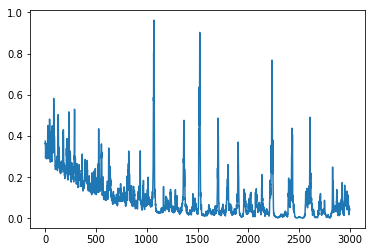

In [299]:
plt.plot(history.history['mean_squared_error'])

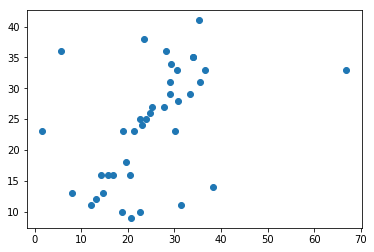

In [300]:
plt.scatter(model.predict(X_test_sc), Y_test)

In [297]:
model.predict(X_test_sc)[0:10]

array([[36.56205 ],
       [33.5479  ],
       [29.445251],
       [16.17342 ],
       [30.35545 ],
       [25.253632],
       [31.007532],
       [19.345835],
       [23.718304],
       [11.677241]], dtype=float32)

In [280]:
Y_test[0:10]

array([33, 35, 23, 16, 28, 26, 31, 18,  9, 11])

In [301]:
model.evaluate(X_test_sc, Y_test)

39/39 [==============================] - 0s 6ms/sample - loss: 113.9940 - mean_squared_error: 113.9940 - mean_absolute_error: 6.5764


[113.99401620718149, 113.99402, 6.5764413]

In [283]:
train_pred = model.predict(X_train_sc)

In [284]:
train_pred

array([[19.630384 ],
       [22.827015 ],
       [43.189194 ],
       [16.828407 ],
       [36.546032 ],
       [13.408375 ],
       [42.09539  ],
       [28.405575 ],
       [34.69947  ],
       [10.175919 ],
       [28.992079 ],
       [33.962082 ],
       [30.997417 ],
       [32.105118 ],
       [40.191456 ],
       [33.035217 ],
       [10.599969 ],
       [ 9.364055 ],
       [ 7.6228004],
       [15.660296 ],
       [19.073092 ],
       [28.58037  ],
       [18.242496 ],
       [24.112274 ],
       [24.569275 ],
       [32.457966 ],
       [29.218596 ],
       [27.640821 ],
       [30.942284 ],
       [15.631084 ],
       [ 9.311327 ],
       [33.56033  ],
       [13.65631  ],
       [14.341925 ],
       [18.321184 ],
       [23.80929  ],
       [39.11985  ],
       [31.773415 ],
       [21.179716 ],
       [22.55966  ],
       [39.988277 ],
       [ 9.957918 ],
       [43.32946  ],
       [37.094646 ],
       [16.322206 ],
       [ 7.4608326],
       [24.270662 ],
       [15.80

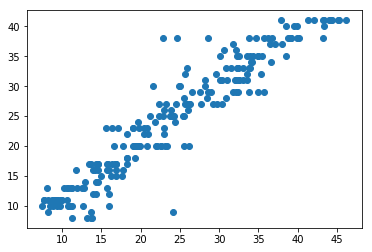

In [285]:
plt.scatter(train_pred, Y_train)